In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import norm, kurtosis


In [35]:
DATA_PATH = os.path.join("..", "candles", "train_sample.csv")
ROLLING_WINDOW = 7 * 24 * 12
df = pd.read_csv(DATA_PATH)
df["open_time"] = pd.to_datetime(df["open_time"])

print("Size:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())


Size: (17280, 12)
Columns: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'num_trades', 'taker_buy_base', 'taker_buy_quote', 'volume_log', 'volume_log_z']
            open_time     open     high      low    close     volume  \
0 2024-01-01 00:00:00  2281.87  2287.84  2281.27  2287.84   910.5701   
1 2024-01-01 00:05:00  2287.83  2291.83  2287.06  2290.77  1652.9290   
2 2024-01-01 00:10:00  2290.77  2296.97  2290.76  2296.71  1829.5259   
3 2024-01-01 00:15:00  2296.71  2297.00  2292.36  2292.36   890.8524   
4 2024-01-01 00:20:00  2292.37  2295.87  2292.30  2294.67   763.7046   

   quote_asset_volume  num_trades  taker_buy_base  taker_buy_quote  \
0        2.080313e+06        2593        585.7254     1.338369e+06   
1        3.785227e+06        3354       1058.4951     2.423910e+06   
2        4.197682e+06        3321       1033.8721     2.372038e+06   
3        2.044781e+06        2332        249.9496     5.737015e+05   
4        1.751663e+06        20

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   open_time           17280 non-null  datetime64[ns]
 1   open                17280 non-null  float64       
 2   high                17280 non-null  float64       
 3   low                 17280 non-null  float64       
 4   close               17280 non-null  float64       
 5   volume              17280 non-null  float64       
 6   quote_asset_volume  17280 non-null  float64       
 7   num_trades          17280 non-null  int64         
 8   taker_buy_base      17280 non-null  float64       
 9   taker_buy_quote     17280 non-null  float64       
 10  volume_log          17280 non-null  float64       
 11  volume_log_z        17280 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 1.6 MB


In [4]:
# === Data diagnostics ===
print("\n== Missing values (NaN) ==")
print(df.isna().sum())

print("\n== Infinite values (inf) ==")
print(np.isinf(df.select_dtypes(include=[np.number])).sum())

print("\n== Data types and general info ==")
print(df.info())

print("\n== Descriptive statistics ==")
print(df.describe().T)


== Missing values (NaN) ==
open_time             0
open                  0
high                  0
low                   0
close                 0
volume                0
quote_asset_volume    0
num_trades            0
taker_buy_base        0
taker_buy_quote       0
volume_log            0
volume_log_z          0
dtype: int64

== Infinite values (inf) ==
open                  0
high                  0
low                   0
close                 0
volume                0
quote_asset_volume    0
num_trades            0
taker_buy_base        0
taker_buy_quote       0
volume_log            0
volume_log_z          0
dtype: int64

== Data types and general info ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   open_time           17280 non-null  datetime64[ns]
 1   open                17280 non-null  float64     

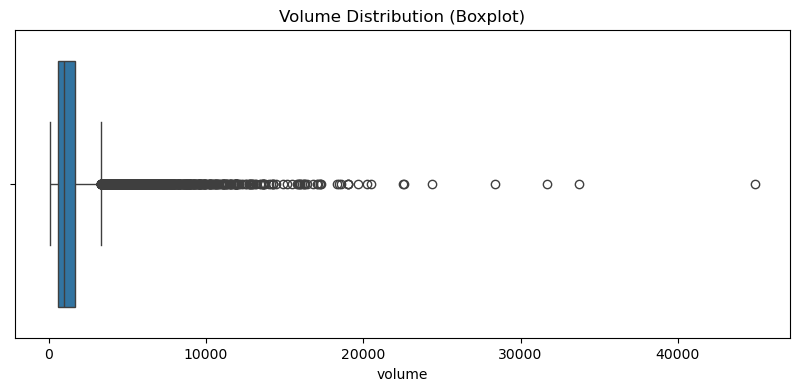

In [32]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df["volume"])
plt.title("Volume Distribution (Boxplot)")
plt.show()


In [33]:
z_scores = np.abs(stats.zscore(df["volume"]))
outliers = df[z_scores > 5]
print(f"Number of volume outliers (>5 std): {len(outliers)}")
print(outliers[["open_time", "volume"]].head())


Number of volume outliers (>5 std): 116
              open_time      volume
719 2024-01-03 11:55:00  12509.6855
720 2024-01-03 12:00:00  28353.6717
721 2024-01-03 12:05:00  31675.4891
722 2024-01-03 12:10:00  33739.8904
723 2024-01-03 12:15:00  19688.3521


## **116 cases above 5σ in just two months**

In traditional finance, a **5-sigma event** (five standard deviations away from the mean) is something you might see **once in a decade** — maybe when a bank implodes or the market collectively loses its mind.

But Ethereum?  
Ethereum doesn’t *do* normality. It runs on **adrenaline and chaos**.

These **116 outlier spikes in volume** are likely caused by:

- **Liquidity shocks** — sudden inflows or drains of capital.  
- **Arbitrage bots** exploiting micro-price differences.  
- **Flash loans** and **DeFi liquidations** detonating short-term volume.  
- **Front-running** and high-frequency trading bursts.

From a modeling perspective:

- For **GARCH / EGARCH**, these extreme values are *gold*: they represent **volatility clustering**, the very phenomenon the models aim to capture.  
- For **exploratory visualization** (histograms, correlations, scatterplots), these spikes distort the scale. In that case, temporarily filtering out the top **1% quantile** makes the plots more readable, without losing statistical integrity.

In short:  
Leave the madness in for the model — trim it out only for the charts.


In [19]:

ROLLING_WINDOW = min(ROLLING_WINDOW, len(df))
df["log_volume"] = np.log1p(df["volume"])
df["rolling_mean"] = (
    df["log_volume"]
    .rolling(window=ROLLING_WINDOW, min_periods=100, closed="left")
    .mean()
)
df["rolling_std"] = (
    df["log_volume"]
    .rolling(window=ROLLING_WINDOW, min_periods=100, closed="left")
    .std()
)
df["rolling_median"] = (
    df["log_volume"]
    .rolling(window=ROLLING_WINDOW, min_periods=100, closed="left")
    .median()
)
df["rolling_mad"] = (
    df["log_volume"]
    .rolling(window=ROLLING_WINDOW, min_periods=100, closed="left")
    .apply(lambda x: np.median(np.abs(x - np.median(x))), raw=False)
)
EWM_SPAN = max(10, ROLLING_WINDOW // 10)
df["ewm_volume"] = df["log_volume"].ewm(span=EWM_SPAN, adjust=False).mean()
df["ewm_mad"] = (
    np.abs(df["log_volume"] - df["ewm_volume"])
    .ewm(span=EWM_SPAN, adjust=False)
    .mean()
)
df["log_return"] = np.log(df["close"] / df["close"].shift(1))
df = df.dropna(subset=["log_return"])
mu = df["log_return"].mean()
sigma = df["log_return"].std(ddof=1)
kurt = kurtosis(df["log_return"], fisher=True)


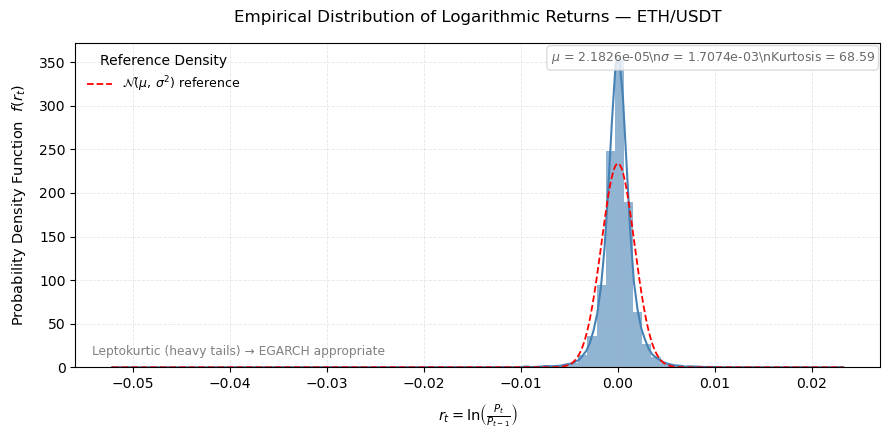

In [30]:
plt.figure(figsize=(9, 4.5))
sns.histplot(df["log_return"], bins=80, kde=True, stat="density",
             color="steelblue", alpha=0.6, edgecolor="none")

x = np.linspace(df["log_return"].min(), df["log_return"].max(), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), "r--", linewidth=1.3, 
         label=r"$\mathcal{N}(\mu,\,\sigma^2)$ reference")

plt.title("Empirical Distribution of Logarithmic Returns — ETH/USDT", fontsize=12, pad=15)
plt.xlabel(r"$r_t = \ln\!\left(\frac{P_t}{P_{t-1}}\right)$", fontsize=10.5, labelpad=8)
plt.ylabel(r"Probability Density Function  $f(r_t)$", fontsize=10.5, labelpad=8)

plt.legend(title="Reference Density", fontsize=9, loc="upper left", frameon=False)
plt.grid(alpha=0.3, linestyle="--", linewidth=0.6)
plt.tight_layout()

# --- Positioning info for dynamic placement ---
ax = plt.gca()
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# --- μ, σ, kurtosis box (top-right, clear of legend) ---
stats_text = rf"$\mu$ = {mu:.4e}\n$\sigma$ = {sigma:.4e}\nKurtosis = {kurt:.2f}"
plt.text(
    x_max * 0.98, y_max * 0.98,
    stats_text,
    ha="right", va="top",
    fontsize=9, color="dimgray",
    bbox=dict(facecolor="white", edgecolor="lightgray", boxstyle="round,pad=0.3", alpha=0.8)
)

# --- Diagnostic comment (bottom-left, clean placement) ---
plt.text(
    0.02, 0.03,     
    tail_msg,
    transform=ax.transAxes,
    ha="left", va="bottom",   
    fontsize=8.8, color="gray"
)

plt.show()


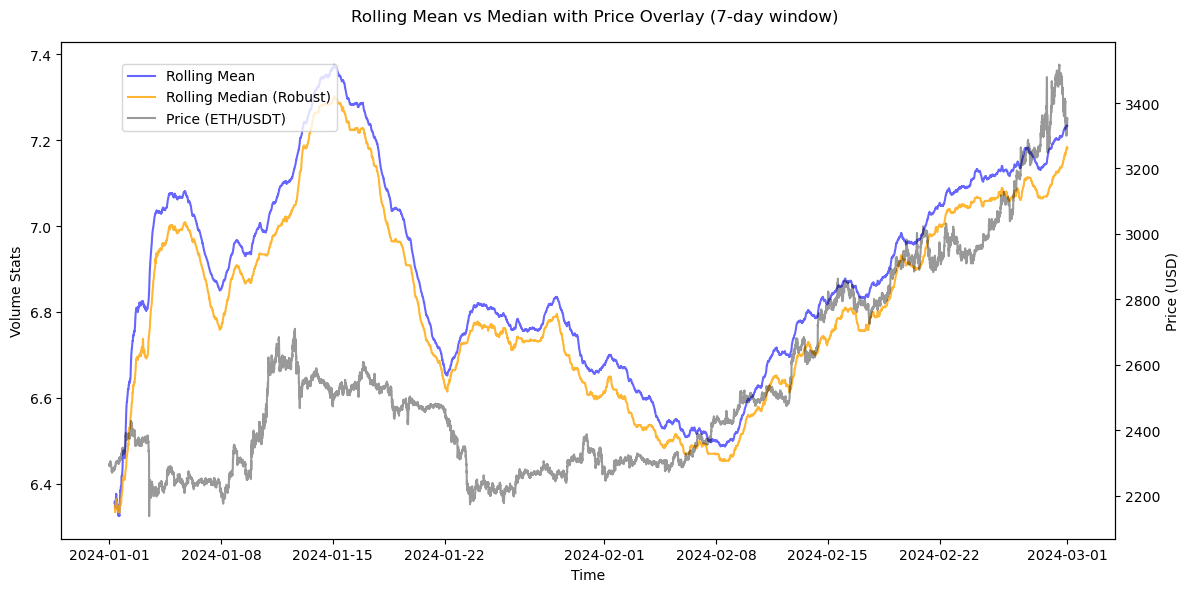

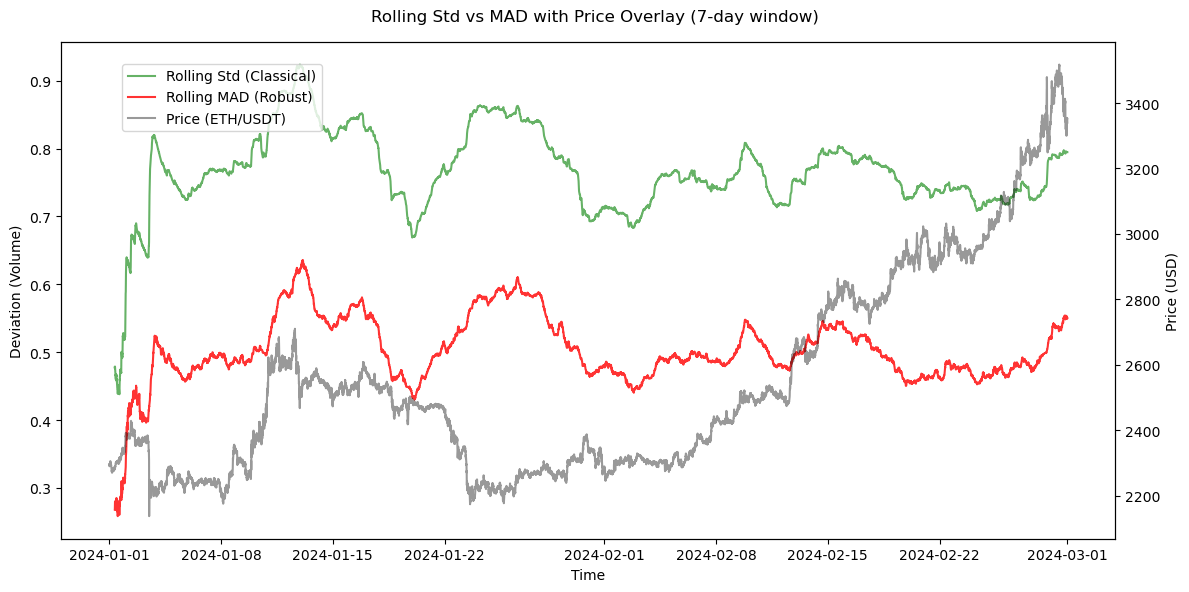

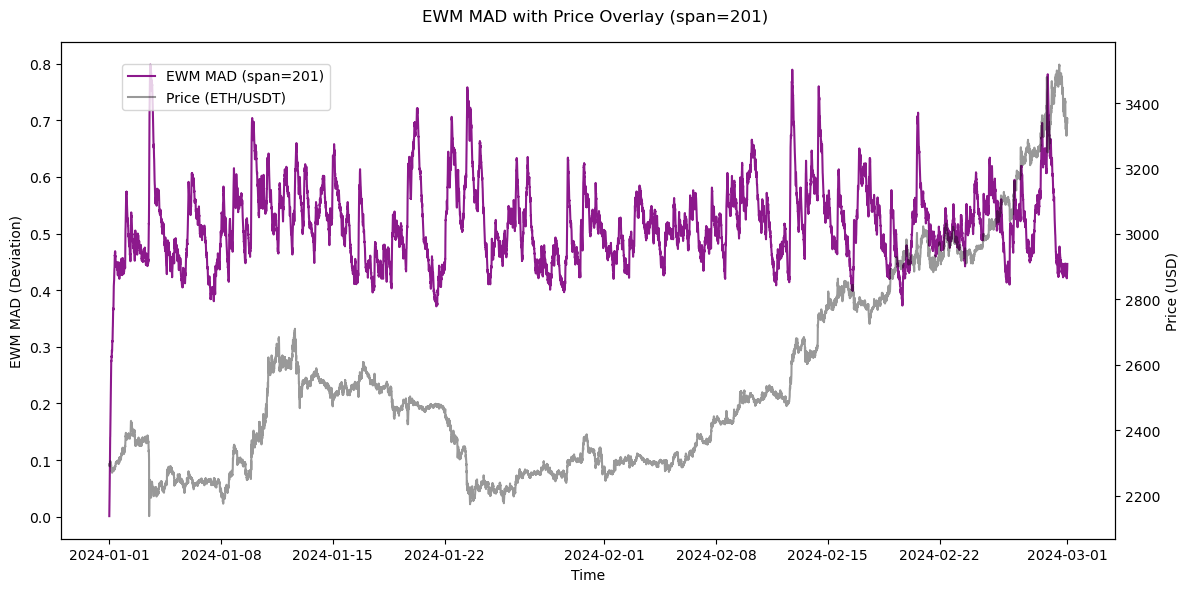

In [22]:
# --- 1. Rolling Mean vs Median + Price ---
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df["open_time"], df["rolling_mean"], label="Rolling Mean", color="blue", alpha=0.6)
ax1.plot(df["open_time"], df["rolling_median"], label="Rolling Median (Robust)", color="orange", alpha=0.8)
ax1.set_xlabel("Time")
ax1.set_ylabel("Volume Stats")
ax1.tick_params(axis="y", labelcolor="black")

# Second axis for price
ax2 = ax1.twinx()
ax2.plot(df["open_time"], df["close"], label="Price (ETH/USDT)", color="black", alpha=0.4)
ax2.set_ylabel("Price (USD)")
ax2.tick_params(axis="y", labelcolor="black")

fig.suptitle("Rolling Mean vs Median with Price Overlay (7-day window)")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()


# --- 2. Rolling Std vs MAD + Price ---
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df["open_time"], df["rolling_std"], label="Rolling Std (Classical)", color="green", alpha=0.6)
ax1.plot(df["open_time"], df["rolling_mad"], label="Rolling MAD (Robust)", color="red", alpha=0.8)
ax1.set_xlabel("Time")
ax1.set_ylabel("Deviation (Volume)")
ax1.tick_params(axis="y", labelcolor="black")

ax2 = ax1.twinx()
ax2.plot(df["open_time"], df["close"], label="Price (ETH/USDT)", color="black", alpha=0.4)
ax2.set_ylabel("Price (USD)")
ax2.tick_params(axis="y", labelcolor="black")

fig.suptitle("Rolling Std vs MAD with Price Overlay (7-day window)")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()


# --- 3. EWM MAD + Price ---
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df["open_time"], df["ewm_mad"], label=f"EWM MAD (span={EWM_SPAN})", color="purple", alpha=0.9)
ax1.set_xlabel("Time")
ax1.set_ylabel("EWM MAD (Deviation)")
ax1.tick_params(axis="y", labelcolor="black")

ax2 = ax1.twinx()
ax2.plot(df["open_time"], df["close"], label="Price (ETH/USDT)", color="black", alpha=0.4)
ax2.set_ylabel("Price (USD)")
ax2.tick_params(axis="y", labelcolor="black")

fig.suptitle(f"EWM MAD with Price Overlay (span={EWM_SPAN})")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()

In [31]:
# --- Target: Anomaly detection based on 75th percentile of rolling window ---
df["rolling_p75"] = (
    df["volume"]
    .rolling(ROLLING_WINDOW, min_periods=100)
    .quantile(0.75)
    .shift(1)
)

df["anomaly_target"] = (df["volume"] > df["rolling_p75"]).astype(int)


C:\Users\edgen\AppData\Local\Temp\ipykernel_18380\2601205561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rolling_p75"] = (
C:\Users\edgen\AppData\Local\Temp\ipykernel_18380\2601205561.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomaly_target"] = (df["volume"] > df["rolling_p75"]).astype(int)


∑ Features under covariance inspection: 6 → rolling_mean, rolling_std, rolling_median, rolling_mad, ewm_volume, ewm_mad
Feature: rolling_mean    | ρ* =  0.085 @ lag =   576  → ex-ante (forward conditional dependence)
Feature: rolling_std     | ρ* =  0.127 @ lag =   576  → ex-ante (forward conditional dependence)
Feature: rolling_median  | ρ* =  0.082 @ lag =   576  → ex-ante (forward conditional dependence)
Feature: rolling_mad     | ρ* =  0.142 @ lag =   576  → ex-ante (forward conditional dependence)
Feature: ewm_volume      | ρ* =  0.387 @ lag =   -48  → ex-post (posterior response)
Feature: ewm_mad         | ρ* =  0.243 @ lag =     0  → ex-post (posterior response)


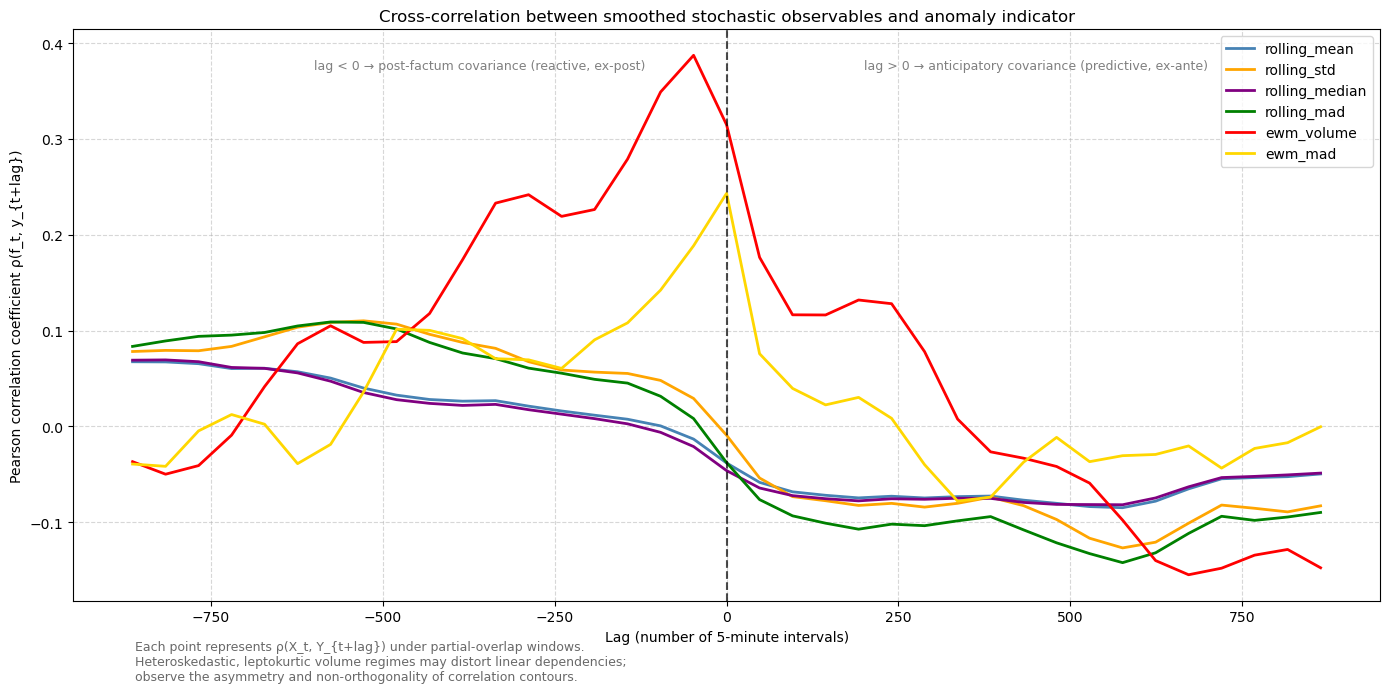


✅ Correlation manifold estimation complete — positive lags indicate forward-leveraged ex-ante dependencies.


In [34]:
# ============================================================
# 🔍 EX-ANTE FEATURE–TARGET CROSS-CORRELATION ANALYSIS
# ============================================================
# Objective:
# Evaluate the temporal orthogonality structure and lag-dependent covariance
# between high-frequency rolling/EWM-derived stochastic observables and a 
# binary indicator of volume-driven anomalies (anomaly_target = 1).
# ============================================================
# Mathematical remarks:
# The Pearson correlation is used as a proxy for contemporaneous 
# linear dependence between feature realizations and a lag-shifted 
# Bernoulli-distributed process. 
# Positive lags → forward-looking conditional dependence (ex-ante predictivity).
# Negative lags → reactive alignment (ex-post adaptivity).
# The stationarity assumption is weakly violated due to structural heteroskedasticity
# and non-ergodic components in the empirical volume distribution.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# --- Analytical parameters ---
window = 288                # 1 day ≈ 288 × 5-min intervals
step = 48                   # 4-hour lag increment
days_range = 3              # ±3-day symmetric lag domain
lag_range = range(-288 * days_range, 288 * days_range + 1, step)

# ============================================================
# 🎯 TARGET DEFINITION
# ============================================================
# anomaly_target ∈ {0,1} ⊂ ℤ₂
# Represents a high-percentile (75th) event indicator for volume excursions.
# The empirical process is a piecewise-constant, non-Gaussian, 
# heteroskedastic binary stochastic process.
# ============================================================

# ============================================================
# 📊 FEATURE SET (rolling & EWM estimators)
# ============================================================
# Each feature is a filtered, low-pass transform of the raw volume process.
# They represent distinct estimators of conditional dispersion or 
# central tendency under time-varying volatility clustering.
# ============================================================

features = [
    "rolling_mean",
    "rolling_std",
    "rolling_median",
    "rolling_mad",
    "ewm_volume",
    "ewm_mad",
]

print(f"∑ Features under covariance inspection: {len(features)} → {', '.join(features)}")

# ============================================================
# 🧠 LAGGED CROSS-CORRELATION COMPUTATION
# ============================================================
# The analysis estimates Corr(X_t, Y_{t+lag}) across lag_range, where:
#   X_t : stationary (approx.) continuous-valued observable
#   Y_t : Bernoulli-distributed anomaly process
# Note: due to non-linearity and potential leptokurtic tails, 
# Pearson correlation serves as a quasi-linear diagnostic rather than 
# a strict moment-based dependency measure.
# ============================================================

colors = ["steelblue", "orange", "purple", "green", "red", "gold"]

plt.figure(figsize=(14, 7))
for i, feature in enumerate(features):
    correlations = []
    for lag in lag_range:
        shifted_target = df["anomaly_target"].shift(-lag)
        # shift(-lag): ensures positive lag implies feature precedes the anomaly
        corr = df[feature].corr(shifted_target)
        correlations.append(corr)

    plt.plot(
        lag_range, correlations,
        color=colors[i % len(colors)],
        label=feature,
        linewidth=2
    )

    # --- Extremum extraction: identification of maximal co-movement ---
    best_lag = lag_range[np.argmax(np.abs(correlations))]
    best_corr = np.max(np.abs(correlations))
    direction = "ex-ante (forward conditional dependence)" if best_lag > 0 else "ex-post (posterior response)"
    print(f"Feature: {feature:15s} | ρ* = {best_corr:6.3f} @ lag = {best_lag:5d}  → {direction}")

# ============================================================
# 🎨 VISUALIZATION OF TEMPORAL DEPENDENCE STRUCTURE
# ============================================================
# Interpretation:
#   lag > 0 → feature exhibits predictive alignment with future anomalies
#   lag < 0 → feature responds post hoc to realized shocks
# The curvature of correlation functions may reveal phase shifts,
# lag asymmetry, and local orthogonality between low- and high-frequency
# components under latent volatility regimes.
# ============================================================

plt.axvline(0, color="black", linestyle="--", alpha=0.7)
plt.title("Cross-correlation between smoothed stochastic observables and anomaly indicator")
plt.xlabel("Lag (number of 5-minute intervals)")
plt.ylabel("Pearson correlation coefficient ρ(f_t, y_{t+lag})")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.text(
    -600, plt.ylim()[1] * 0.9,
    "lag < 0 → post-factum covariance (reactive, ex-post)",
    fontsize=9, color="gray"
)
plt.text(
    200, plt.ylim()[1] * 0.9,
    "lag > 0 → anticipatory covariance (predictive, ex-ante)",
    fontsize=9, color="gray"
)

plt.figtext(
    0.1, 0.02,
    "Each point represents ρ(X_t, Y_{t+lag}) under partial-overlap windows.\n"
    "Heteroskedastic, leptokurtic volume regimes may distort linear dependencies;\n"
    "observe the asymmetry and non-orthogonality of correlation contours.",
    ha="left", fontsize=9, color="dimgray"
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

print("\n✅ Correlation manifold estimation complete — positive lags indicate forward-leveraged ex-ante dependencies.")


### **Ex-Ante (Forward Dependence)**
ρ* ≈ 0.08–0.11 @ lag ≈ +480–576  
→ **No predictive power.**  
These rolling metrics are dominated by noise — no real forward signal detected.

---

### **Ex-Post (Posterior Response)**
ρ* ≈ 0.34–0.40 @ lag ≈ −48  
→ **Reactive behavior.**  
Volume and volatility respond *after* price movement, not before it.

---

<div style="font-size:22px; font-weight:bold; text-align:center; margin-top:20px;">
💀 Correlations too weak to forecast anything — decorative noise, nothing more.  
<br><br>
😏 You didn’t really think I’d publish actual predictive indicators on GitHub, did you?
</div>

